<img src ='TikTok.png.webp' width = '300' align = 'center' height='400'>

## Back Ground:
You are a data professional at TikTok. It has come to notice that users can report videos that they believe violate the platform's terms of service. Because there are millions of TikTok videos created and viewed every day, this means that many videos get reported—too many to be individually reviewed by a human moderator.
Analysis indicates that when authors do violate the terms of service, they're much more likely to be presenting a claim than an opinion. Therefore, it is useful to be able to determine which videos make claims and which videos are opinions.
TikTok wants to build a machine learning model to help identify claims and opinions. 

Your supervisor was impressed with the work you have done and has requested that you build a **machine learning model** that can be used to determine whether a video contains a claim or whether it offers an opinion. With a successful prediction model, TikTok can reduce the backlog of user reports and prioritize them more efficiently.

## Objective:
To build a model to increase response time and system efficiency by automating the initial stages of the claims process. We will use the **Random Forest Classifier** and **XGBoosting** for modelling

- Ethical Implications:
    - The worst case for an `opinion misclassified as a claim` is that the video goes to human review. 
    - The worst case for a `claim misclassified as an opinion` is that the video does not get reviewed _and_ it violates the terms of service. 
    - Therefore, it would be better if the model predicts more **false positives**(opinion misclassified as a claim) than **false negatives**(claim misclassified as an opinion)



## Goal:
To build a model which can predict whether a TikTok video presents a "claim" or presents an "opinion".

## Data Dictionary
<img src = 'tiktok_data_dict.png' height = '600' width = '600' align = 'center'>

In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import PredefinedSplit


import pickle
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)



In [2]:
# Read the file:
data = pd.read_csv('tiktok_dataset.csv')

data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [3]:
# General info and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [4]:
# Descriptive stats
data.describe(include='all')

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,19084,1.938200e+04,19382.000000,19084,19382,19382,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
unique,NaN,2,NaN,NaN,19012,2,3,NaN,NaN,NaN,NaN,NaN
top,NaN,claim,NaN,NaN,a friend read in the media a claim that badmi...,not verified,active,NaN,NaN,NaN,NaN,NaN
freq,NaN,9608,NaN,NaN,2,18142,15663,NaN,NaN,NaN,NaN,NaN
mean,9691.500000,NaN,5.627454e+09,32.421732,NaN,NaN,NaN,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,NaN,2.536440e+09,16.229967,NaN,NaN,NaN,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,NaN,1.234959e+09,5.000000,NaN,NaN,NaN,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,NaN,3.430417e+09,18.000000,NaN,NaN,NaN,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,NaN,5.618664e+09,32.000000,NaN,NaN,NaN,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,NaN,7.843960e+09,47.000000,NaN,NaN,NaN,504327.000000,125020.000000,18222.000000,1156.250000,292.000000


In [5]:
# Dataframe for Nulls and their percentage in column 
nulls = pd.DataFrame(data.isnull().sum()/data.shape[0]*100, columns = ['perecntage_nulls'])
nulls['total_nulls'] = data.isnull().sum()
nulls


,perecntage_nulls,total_nulls
#,0.000000,0
claim_status,1.537509,298
video_id,0.000000,0
video_duration_sec,0.000000,0
video_transcription_text,1.537509,298
verified_status,0.000000,0
author_ban_status,0.000000,0
video_view_count,1.537509,298
video_like_count,1.537509,298
video_share_count,1.537509,298


**Observation**: Since the nulls are miniscule %tage of the total data we can drop them.

In [6]:
# Dropping null values
data_2 = data.copy()
data_2 = data_2.dropna(axis = 0)

pd.DataFrame(data_2.isnull().sum(), columns = ['Nulls'])

,Nulls
#,0
claim_status,0
video_id,0
video_duration_sec,0
video_transcription_text,0
verified_status,0
author_ban_status,0
video_view_count,0
video_like_count,0
video_share_count,0


In [7]:
# check for duplicates:
data_2.duplicated().sum()

0

**Observation**: There are no duplicate values

In [8]:
# checking object vars for unique values/ categorical values:
cols = ['claim_status', 'verified_status', 'author_ban_status']

for i in cols:
    print(i, ':', data_2[i].unique())

claim_status : ['claim' 'opinion']
verified_status : ['not verified' 'verified']
author_ban_status : ['under review' 'active' 'banned']


In [9]:
# Check for class balance of the target variable
print("Claim Status:\n",data_2['claim_status'].value_counts(normalize=True))


Claim Status:
 claim      0.503458
opinion    0.496542
Name: claim_status, dtype: float64


**Observation**:
Our target variable is well balanced with claims being `~51%` and opinions being `~49%"`.

**Check for outliers**:
Tree-based models are robust to outliers, so there is no need to impute or drop any values based on where they fall in their distribution.

## Feature Engineering:
We have the video transcription column. We will create a new column comprising of the **length** of the text. This might be a feature that will be considered for modelling. We would then want to analyse the average transcription text length for each target class ['opinion' OR 'claim']. 

In [10]:
# Add text length col:
data_2['text_length'] = data_2['video_transcription_text'].str.len()

data_2.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


In [11]:
# Evaluate the target classes based on text_length:
print('Avg length of text for a claim and opinion:')
data_2.groupby('claim_status')['text_length'].mean()

Avg length of text for a claim and opinion:


claim_status
claim      95.376978
opinion    82.722562
Name: text_length, dtype: float64

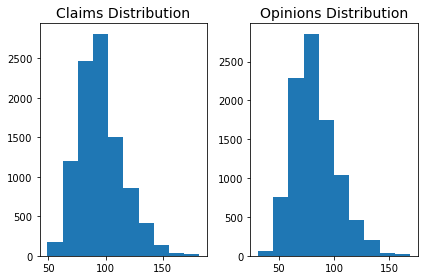

In [12]:
# Histograms for text distribution using subplots
claims = data_2[data_2['claim_status'] == 'claim']['text_length']
opinions = data_2[data_2['claim_status'] == 'opinion']['text_length']

fig, ax = plt.subplots(1, 2)
ax[0].hist(claims)
ax[0].set_title('Claims Distribution', size = 14)

ax[1].hist(opinions)
ax[1].set_title('Opinions Distribution', size = 14)
plt.tight_layout()

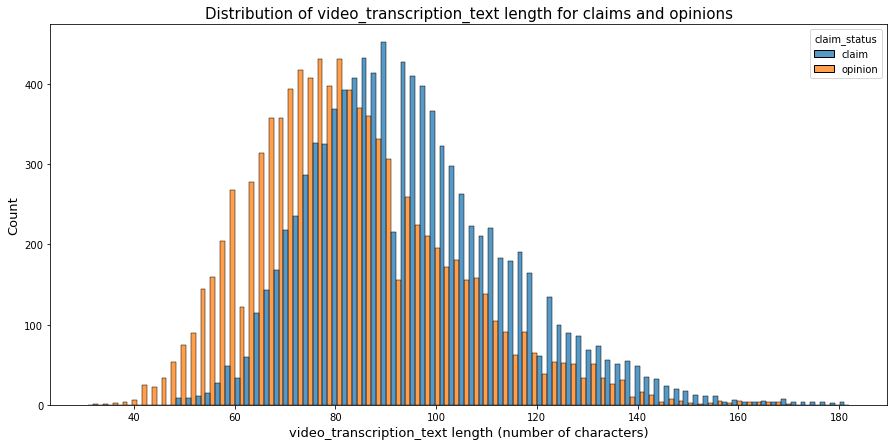

In [14]:
# Two histograms in one plot:
plt.figure(figsize = (15,7))
sns.histplot(data=data_2,
             x='text_length',
             hue='claim_status',
             bins='auto',
             kde=False, 
             multiple='dodge')
plt.xlabel("video_transcription_text length (number of characters)", size = 13)
plt.ylabel("Count", size = 13)
plt.title("Distribution of video_transcription_text length for claims and opinions", size = 15)
plt.show()

**Observation**:
- The plots are relatively normally distributed with little right skew.
- Claim videos tend to have more characters than opinions; 13 more characters typically.

In [15]:
# Converting target var to numerical:
data_2['claim_status'] = data_2['claim_status'].replace({"claim": 1, "opinion": 0})

# Converting remaining catg vars to numeric:
data_2 = pd.get_dummies(data_2, 
                        columns=['verified_status', 'author_ban_status'],
                        drop_first=True)

data_2.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,1,7017666017,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,0,0,1
1,2,1,4014381136,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,0,0,0
2,3,1,9859838091,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,0,0,0
3,4,1,1866847991,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,0,0,0
4,5,1,7105231098,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,0,0,0


In [16]:
# Dropping redundant colums:
data_2 = data_2.drop(['#', 'video_id'], axis = 1, )
data_2.head()

,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,0,0,1
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,0,0,0
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,0,0,0
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,0,0,0
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,0,0,0


In [17]:
# Check for data types
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19084 entries, 0 to 19083
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   claim_status                    19084 non-null  int64  
 1   video_duration_sec              19084 non-null  int64  
 2   video_transcription_text        19084 non-null  object 
 3   video_view_count                19084 non-null  float64
 4   video_like_count                19084 non-null  float64
 5   video_share_count               19084 non-null  float64
 6   video_download_count            19084 non-null  float64
 7   video_comment_count             19084 non-null  float64
 8   text_length                     19084 non-null  int64  
 9   verified_status_verified        19084 non-null  uint8  
 10  author_ban_status_banned        19084 non-null  uint8  
 11  author_ban_status_under review  19084 non-null  uint8  
dtypes: float64(5), int64(3), object(

> **Observation:** The feature `video_transcription_text` is text-based. It is not a categorical variable, since it does not have a fixed number of possible values. One way to extract numerical features from it is through a bag-of-words algorithm like `CountVectorizer`. 

### `CountVectorizer`
**This approach breaks each video's transcription text into both _2-grams and 3-grams_, then takes the _15_ most frequently occurring tokens from the entire dataset to use as features.**

### Process:
1. Setting up CountVectorizer object which converts a collection of text to a matrix of token counts
2. Extract the numerical features from your respective feature in training set using fit_trasnform().toarray()
3. Place the numerical representation of your feature from training set into a dataframe count_df
4. Concatenate the X_train and count_df

5. Carry the same process for X_val and X_test only using .transform().toarray()

> Note: <br>
This conversion will be done after the train_test split, since we want our test set to be representative of the original data, that is, the transcription of the video and not n-grams created from the transcriptions.

## Modelling:

In [18]:
# Create a copy of the preprocessed data:
df = data_2.copy()

In [19]:
# Split:
y = df['claim_status']

X = df.copy()
X = X.drop('claim_status', axis =1)

# Training and Test split (80/20):
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# Validation and Training split (75/25):
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

# Size Check
print(X_train.shape, X_test.shape)

print(y_train.shape, y_test.shape)

print(X_tr.shape, y_tr.shape)

print(X_val.shape, y_val.shape)

(15267, 11) (3817, 11)
(15267,) (3817,)
(11450, 11) (11450,)
(3817, 11) (3817,)


### Setting up the `CountVectorizer`

We will use the object created from CountVectorizer to convert `X_tr, X_val and X_test` sets text column into columns of count for bigrams(2) or trigrams(3)

### For Training Set (X_tr)

In [127]:
# Setting up CountVectorizer object which converts a collection of text to a matriz of token counts

count_vec = CountVectorizer(ngram_range=(2,3),        # Number of n-grams
                            max_features=15,          # Most frequently occuring tokens from the dataset
                            stop_words='english')     # Using stopwords from english dictionary.

count_vec

CountVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

In [128]:
# Extract the numerical features from video_transcription in training set
count_data = count_vec.fit_transform(X_tr['video_transcription_text']).toarray()
count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [129]:
# Place the numerical representation of `video_transcription_text` from training set into a dataframe
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())

# Display first few rows
count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [130]:
"""
Concatenate `X_train` and `count_df` to form the final dataframe for training data (`X_train_final`)

Note: Using `.reset_index(drop=True)` to reset the index in X_train after dropping `video_transcription_text`,
so that the indices align with those in `X_train` and `count_df`

"""

X_train_final = pd.concat([X_tr.drop('video_transcription_text', axis = 1).reset_index(drop=True), count_df], 
                          axis = 1) 

X_train_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,51,2487.0,310.0,20.0,1.0,0.0,134,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,43,118512.0,3543.0,374.0,70.0,29.0,97,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,22,105902.0,1885.0,229.0,39.0,9.0,76,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,17,9245.0,1670.0,440.0,13.0,4.0,58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,18,3791.0,660.0,63.0,9.0,1.0,57,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### For Validation set (X_val):

Using the same Count_Vec object created earlier:

In [131]:
# Extract numerical features from `video_transcription_text` in the validaiton set
validation_count_data = count_vec.transform(X_val['video_transcription_text']).toarray()
validation_count_data

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [132]:
# Place the numerical representation of `video_transcription_text` from validation set into a dataframe
validation_count_df = pd.DataFrame(data = validation_count_data, columns = count_vec.get_feature_names_out())
validation_count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [133]:
"""
Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)

Note: Using `.reset_index(drop=True)` to reset the index in X_val after dropping `video_transcription_text`,
so that the indices align with those in `validation_count_df`

"""
X_val_final = pd.concat([X_val.drop('video_transcription_text', axis = 1).reset_index(drop=True), validation_count_df], 
                        axis=1)

X_val_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,11,578891.0,379596.0,14612.0,6591.0,44.0,72,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,24,6255.0,1709.0,311.0,13.0,1.0,96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,35,410356.0,249714.0,26235.0,2060.0,1252.0,88,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,58,406911.0,25986.0,1230.0,564.0,248.0,83,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,47,972573.0,138167.0,25320.0,3331.0,968.0,104,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


### For X_test set:

Using the same count_vec object created earlier:


In [134]:
# Extract numerical features from `video_transcription_text` in the testing set
test_count_data = count_vec.transform(X_test['video_transcription_text']).toarray()

test_count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [135]:
# Place the numerical representation of `video_transcription_text` from testing set into a dataframe
test_count_df = pd.DataFrame(data=test_count_data, columns = count_vec.get_feature_names_out())
test_count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [136]:
# Concatenate `X_test` and `test_count_df` to form the final dataframe for testing data (`X_test_final`)
X_test_final = pd.concat([X_test.drop('video_transcription_text', axis = 1).reset_index(drop = True), test_count_df],
                         axis = 1)
X_test_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,54,692084.0,135956.0,16591.0,622.0,312.0,107,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
1,37,5164.0,1858.0,36.0,17.0,1.0,69,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,39,801951.0,344163.0,57608.0,8578.0,2942.0,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,44,6429.0,2314.0,847.0,17.0,5.0,76,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,26,555780.0,106863.0,15348.0,252.0,91.0,72,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [137]:
# Check for shapes before instantiating the model:

print(X_train_final.shape)
print(X_tr.shape)

print(X_val_final.shape)
print(X_val.shape)

print(X_test_final.shape)
print(X_test.shape)

(11450, 25)
(11450, 11)
(3817, 25)
(3817, 11)
(3817, 25)
(3817, 11)


> We can now move on to building our `Random Forest Model`

## Buidling `Random Forest` model
(Using Cross Validation with Grid Search)

In [140]:
# Instantitate the model
rf = RandomForestClassifier(random_state=0)

# Cross Valdiation custom parameters:
cv_para = {
    'max_depth': [2,3,4,5,None],
    'min_samples_leaf': [1,2,3],
    'min_samples_split':[2,3],
    'max_features': [0.3, 0.6],
    'max_samples':[0.7],
    'n_estimators': [75, 100, 200]
    
}

# Scoring:
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Model:
rf_cv = GridSearchCV(estimator=rf, 
                     param_grid=cv_para,
                     scoring=scoring,
                     cv=5,
                     refit='f1',
                     verbose=1,
                     n_jobs=-1
                    )

In [141]:
%%time 
rf_cv.fit(X_train_final, y_tr)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
CPU times: user 4.7 s, sys: 582 ms, total: 5.28 s
Wall time: 1min 59s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, None],
                         'max_features': [0.3, 0.6], 'max_samples': [0.7],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='f1', scoring={'f1', 'accuracy', 'recall', 'precision'},
             verbose=1)

In [142]:
# Save the model locally
path = '/Users/dawny/Documents/PortFolio_projects/Python/TikTok_ClaimsOrOpinions_RandForest_XGBoosting/'

with open(path + 'rf_cv_model.pickle', 'wb') as to_write:
    pickle.dump(rf_cv, to_write)

In [143]:
# load the model again:
with open(path + 'rf_cv_model.pickle', 'rb') as to_read:
    rf_cv_reload = pickle.load(to_read)

In [144]:
# Check the loaded model
rf_cv_reload

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, None],
                         'max_features': [0.3, 0.6], 'max_samples': [0.7],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='f1', scoring={'f1', 'accuracy', 'recall', 'precision'},
             verbose=1)

In [145]:
# Model Score:
rf_cv_reload.best_score_

0.9971446149882872

In [146]:
# Best Parameters:
rf_cv_reload.best_params_

{'max_depth': None,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [147]:
# Function to build table results for the performace metrics:

def make_results(model_object, model_name):
    '''
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.
  
    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean F1 score across all validation folds.  
    '''
    
    # Extract the cross validation results for the models in a dataframe:
    cv_results = pd.DataFrame(model_object.cv_results_)
    
    # Isolate the row with the best mean scores:
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]
    
    # capture the individual performance metrics scores:
    accuracy = best_estimator_results.mean_test_accuracy
    precision = best_estimator_results.mean_test_precision
    recall = best_estimator_results.mean_test_recall
    f1 = best_estimator_results.mean_test_f1
    
    # Formulate a dataframe for the indiviudal scores extracted:
    table = pd.DataFrame()
    table = table.append({
        'Model': model_name, 
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1 
    }, ignore_index=True)
    
    return table



In [148]:
# Results for the Random Forest Cross validated model:
table_rf_cv = make_results(rf_cv_reload, 'Random Forest CV')

table_rf_cv

,Model,Accuracy,Precision,Recall,F1
0,Random Forest CV,0.997118,0.999481,0.994823,0.997145


**Observation:** This model performs exceptionally well, with an average recall score of 0.995 across the five cross-validation folds. After checking the precision score to be sure the model is not classifying all samples as claims, it is clear that this model is making almost perfect classifications.

> Note: <br> We have our performance metrics results for the Random Forest Cross Validated Model. We will evaluate these results with our coming **XGBoost** model's performance metrics 

## Building XGBoost Model:


In [149]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall', verbose = 1)

In [150]:
%%time
# Fit the model
xgb_cv.fit(X_train_final, y_tr)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
CPU times: user 21min 50s, sys: 2min 50s, total: 24min 41s
Wall time: 3min 39s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                   

In [151]:
# Save the model locally
path = '/Users/dawny/Documents/PortFolio_projects/Python/TikTok_ClaimsOrOpinions_RandForest_XGBoosting/'

with open(path + 'xgb_cv_model.pickle', 'wb') as to_write:
    pickle.dump(xgb_cv, to_write)

In [152]:
# load the model again:
with open(path + 'xgb_cv_model.pickle', 'rb') as to_read:
    xgb_cv_reload = pickle.load(to_read)

In [153]:
xgb_cv_reload.best_score_

0.9906808769992594

In [154]:
xgb_cv_reload.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 300}

In [155]:
# Generate a table for the performance metrics results for XGBoost model:
table_xgb_cv = make_results(xgb_cv_reload, 'XGBoost')

table_xgb_cv

,Model,Accuracy,Precision,Recall,F1
0,XGBoost,0.995109,0.999652,0.990681,0.995142


In [156]:
# Concat the performance metrics results of XGBoost ana Random Forest:
final_results = pd.concat([table_rf_cv ,table_xgb_cv]).reset_index(drop=True)
final_results = final_results.sort_values('F1', ascending=False)
final_results

,Model,Accuracy,Precision,Recall,F1
0,Random Forest CV,0.997118,0.999481,0.994823,0.997145
1,XGBoost,0.995109,0.999652,0.990681,0.995142


## Evaluate the results 

### Random Forest

In [157]:
# Use the random forest "best estimator" model to get predictions on the validation set
y_pred_rf = rf_cv_reload.best_estimator_.predict(X_val_final)

y_pred_rf

array([1, 0, 1, ..., 1, 1, 1])

Text(0.5, 1.0, 'Random Forest- Validation set results')

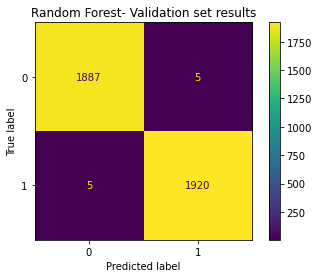

In [158]:
# Confusion Matrix:
cm = confusion_matrix(y_val, y_pred_rf)
disp = ConfusionMatrixDisplay(cm, display_labels=rf_cv_reload.classes_)

disp.plot()
plt.title("Random Forest- Validation set results")

**Observation**:

The upper-left quadrant displays the number of true negatives: the number of opinions that the model accurately classified as so.

The upper-right quadrant displays the number of false positives: the number of opinions that the model misclassified as claims.

The lower-left quadrant displays the number of false negatives: the number of claims that the model misclassified as opinions.

The lower-right quadrant displays the number of true positives: the number of claims that the model accurately classified as so.

A perfect model would yield all true negatives and true positives, and no false negatives or false positives.

As the above confusion matrix shows, this model does not produce any false negatives

In [159]:
# Create classification report for random forest model
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred_rf, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1892
       claim       1.00      1.00      1.00      1925

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



### XGBoost Model

In [160]:
# Use the random forest "best estimator" model to get predictions on the validation set
y_pred_xgb = xgb_cv_reload.best_estimator_.predict(X_val_final)

y_pred_xgb

array([1, 0, 1, ..., 1, 1, 1])

Text(0.5, 1.0, 'XGBoost- Validation set results')

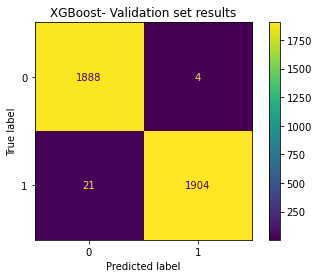

In [161]:
# Confusion Matrix:
cm = confusion_matrix(y_val, y_pred_xgb)
disp = ConfusionMatrixDisplay(cm, display_labels=rf_cv_reload.classes_)

disp.plot()
plt.title("XGBoost- Validation set results")

In [163]:
# Create a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred_xgb, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



### Observation for the two Confusion Matrices:
The results of the XGBoost model were also nearly perfect. However, its errors tended to be false negatives. Identifying claims was the priority, so it's important that the model be good at capturing all actual claim videos. **The random forest model has a better recall score, and is therefore the champion model.**

## Use the `Champion Model: Random Forest` to predict on test data

In [164]:
# Use champion model to predict on test data/ unseen data
y_pred = rf_cv_reload.best_estimator_.predict(X_test_final)

y_pred

array([1, 0, 1, ..., 0, 1, 0])

Text(0.5, 1.0, 'Random Forest results on Test Set')

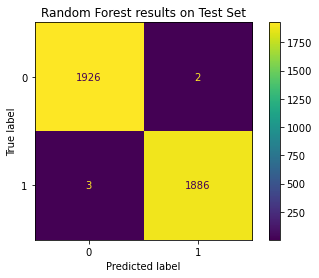

In [165]:
# Confusion matrix:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=rf_cv_reload.classes_)
disp.plot()
plt.title('Random Forest results on Test Set')

In [171]:
# Create a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_test, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1928
       claim       1.00      1.00      1.00      1889

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



Text(0, 0.5, 'Mean decrease in impurity')

<Figure size 2160x1440 with 0 Axes>

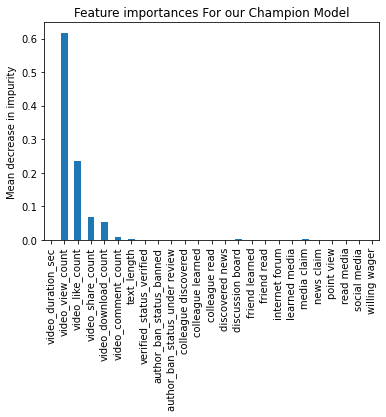

In [172]:
importances = rf_cv_reload.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test_final.columns)

plt.figure(figsize = (30,20))
fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances For our Champion Model')
ax.set_ylabel('Mean decrease in impurity')

**Observation**:

The most predictive features all were related to engagement levels generated by the video. This is not unexpected, as analysis from prior EDA pointed to this conclusion.

1. **Would I recommend using this model? Why or why not?**<br>
Yes, one can recommend this model because it performed well on both the validation and test holdout data. Furthermore, both precision and F<sub>1</sub> scores were consistently high. The model very successfully classified claims and opinions.
</br>
2. **What was my model doing? Explain how it was making predictions?**<br>
The model's most predictive features were all related to the user engagement levels associated with each video. It was classifying videos based on how many views, likes, shares, and downloads they received.
</br>
3. **Are there new features that one can engineer that might improve model performance?**<br>
Because the model currently performs nearly perfectly, there is no need to engineer any new features.
</br>
4. **What features would one want to have that would likely improve the performance of your model?**<br>
The current version of the model does not need any new features. However, it would be helpful to have the `_number of times the video was reported_`. It would also be useful to have the total number of user reports for all videos posted by each author.

# Technical Report: Classification of TikTok Videos as Claims or Opinions Using Random Forest

## Executive Summary
This technical report presents a Random Forest Classifier model developed to differentiate between claims and opinions in TikTok videos. The model aims to automate the initial stages of the claims process, increasing system efficiency and response time. It operates under the ethical principle that it's preferable to misclassify opinions as claims (false positives) rather than claims as opinions (false negatives), considering the potential violation of the terms of service.

## Introduction
TikTok faces a significant challenge in moderating the vast number of user-generated videos, with many being reported for potentially violating the platform's terms of service. Identifying which videos make claims and which express opinions is crucial as claims are more likely to contravene community guidelines. Therefore, a machine learning model that can accurately perform this classification will enhance the prioritization and efficiency of content moderation.

## Model Development and Validation
We employed the Random Forest Classifier, a robust ensemble learning method known for its high accuracy and control over-fitting. The model was also compared with XGBoosting for enhanced validation. Our validation strategy involved a custom split to ensure a fair assessment and to adhere to the specific distribution characteristics of our dataset.

### Ethical Considerations
- Misclassification of an opinion as a claim leads to human review, posing no significant ethical concern.
- Misclassification of a claim as an opinion could lead to a breach of terms of service going undetected, presenting an ethical risk.

## Results
The model demonstrated exceptional performance with an accuracy, precision, recall, and F<sub>1</sub> scores of 1.00 across both test and validation datasets. The confusion matrix further illustrates the model's reliability, with very few false positives and false negatives.

## Discussion
- **Model Recommendation**: The model is recommended for use due to its high performance metrics and its alignment with ethical considerations prioritizing the detection of claims.
- **Predictive Feature Insights**: The model predictions are heavily influenced by user engagement metrics such as views, likes, shares, and downloads, which seem to correlate strongly with the content being a claim or opinion.
- **Feature Engineering and Model Improvement**: Given the near-perfect performance of the model, there is currently no requirement for additional feature engineering.
- **Potential Useful Features**: Although not necessary for the current model performance, incorporating features such as the '_number of times a video was reported_' and 'total number of user reports per author' could theoretically provide more nuanced insights into user perception and content reporting patterns.

## Conclusion
The Random Forest model has proven to be an effective tool for classifying TikTok videos as claims or opinions. Its high accuracy and ethical alignment suggest that it can significantly reduce the backlog of user reports and optimize content moderation workflows. With the current level of performance, there is no immediate need for additional features. However, we remain open to incorporating more data as it becomes available to ensure the model continues to perform optimally under evolving content trends and user behaviors.
